# Build Your Own U-Net

<hr style="height:2px;">

In this notebook, we will implement a U-Net architecture. Through this exercise you should gain an understanding of the U-Net architecture in particular as well as learn how to approach the implementation of an architecture in general and familiarize yourself a bit more with the inner workings of pytorch.

The exercise is split into three parts:

In part 1 you will implement the building blocks of the U-Net. That includes the convolutions, downsampling, upsampling and skip connections. We will go in the order of how difficult they are to implement.

In part 2 you will combine the modules you've built in part 1 to implement the U-Net module.

In part 3 and 4 are light on coding tasks but you will learn about two important concepts: receptive fields and translational equivariance.

Finally, in part 5 you will train your first U-Net of the course! This will just be a first flavor though since you will learn much more about that in the next exercise.


Written by Larissa Heinrich, Caroline Malin-Mayor, and Morgan Schwartz, with inspiration from William Patton.

<hr style="height:2px;">

## The libraries

In [1]:
%matplotlib inline
import numpy as np
import torch
import subprocess
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

import unet_tests
from local import (
    NucleiDataset,
    apply_and_show_random_image,
    plot_receptive_field,
    show_random_dataset_image,
    pad_to_size,
    unnormalize,
)

In [2]:
# make sure gpu is available. Please call a TA if this cell fails
assert torch.cuda.is_available()

## The Dataset
For our segmentation exercises, we will be using a nucleus segmentation dataset from [Kaggle 2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018/data). We have downloaded the dataset during setup and we provided a pytorch Dataset called `NucleiDataset` which we will use for training later. In addition to training, we will use these images to visualize the output of the individual building blocks of the U-Net we will be implementing.
Below, we create a dataset and then visualize a random image.

In [3]:
dataset = NucleiDataset("nuclei_train_data")

Image size is {torch.Size([256, 256])}


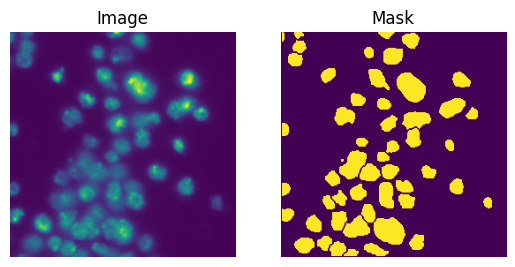

In [4]:
show_random_dataset_image(dataset)

Rerun the cell above a few times to see different images.

<hr style="height:2px;">

## The Components of a U-Net

The [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) architecture has proven to outperform the other architectures in segmenting biological and medical images. It is also commonly used for other tasks that require the output to be the same resolution as the input, such as style transfer and denoising. Below is an overview figure of the U-Net architecture from the original [paper](https://arxiv.org/pdf/1505.04597.pdf). We will go through each of the components first (hint: all of them can be found in the list of PyTorch modules [here](https://pytorch.org/docs/stable/nn.html#convolution-layers)), and then fit them all together to make our very own U-Net.

<img src="static/unet.png" alt="UNet" style="width: 1500px;"/>

### Component 1: Upsampling

We will start with the Upsample module that we will use in our U-Net. The right side of the U-Net contains upsampling between the levels. There are many ways to upsample: in the original U-Net, they used a transposed convolution, but this has since fallen a bit out of fashion so we will use the PyTorch Upsample Module [torch.nn.Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample) instead.

#### Pytorch Modules
Modules are the building blocks of PyTorch models, and contain lots of magic that makes training models easy. If you aren't familiar with PyTorch modules, take a look at the official documentation [here](https://pytorch.org/docs/stable/notes/modules.html). For our purposes, it is crucial to note how Modules can have submodules defined in the `__init__` function, and how the `forward` function is defined and called.

In [5]:
# Here we make fake input to illustrate the upsampling techniques
# Pytorch expects a batch and channel dimension before the actual data,
# So this simulates a 1D input
sample_1d_input = torch.tensor([[[1, 2, 3, 4]]], dtype=torch.float64)
# And this simulates a 2D input
sample_2d_input = torch.tensor(
    [[[[1, 2], [3, 4]]]],
    dtype=torch.float64,
)
sample_2d_input.shape, sample_2d_input

(torch.Size([1, 1, 2, 2]),
 tensor([[[[1., 2.],
           [3., 4.]]]], dtype=torch.float64))

<div class="alert alert-block alert-info">
    <h4>Task 1: Try out different upsampling techniques</h4>
    <p>For our U-net, we will use the built-in PyTorch Upsample Module. Here we will practice declaring and calling an Upsample module with different parameters.</p>
    <ol>
        <li>Declare an instance of the pytorch Upsample module with <code style="color: black">scale_factor</code> 2 and mode <code>"nearest"</code>.</li>
        <li>Call the instance of Upsample on the <code>sample_2d_input</code> to see what the nearest mode does.</li>
        <li>Vary the scale factor and mode to see what changes. Check the documentation for possible modes and required input dimensions.</li>
    </ol>
</div>

In [6]:
# TASK 1.1: initialize  an upsample module
up = torch.nn.Upsample(scale_factor=2, mode="nearest")

# TASK 1.2: apply your upsample module to `sample_2d_input`

# YOUR CODE HERE
out = up(sample_2d_input)
out

tensor([[[[1., 1., 2., 2.],
          [1., 1., 2., 2.],
          [3., 3., 4., 4.],
          [3., 3., 4., 4.]]]], dtype=torch.float64)

In [7]:
# TASK 1.3: vary scale factor and mode
# YOUR CODE HERE
up = torch.nn.Upsample(scale_factor=4, mode="nearest")
out = up(sample_2d_input)
out

tensor([[[[1., 1., 1., 1., 2., 2., 2., 2.],
          [1., 1., 1., 1., 2., 2., 2., 2.],
          [1., 1., 1., 1., 2., 2., 2., 2.],
          [1., 1., 1., 1., 2., 2., 2., 2.],
          [3., 3., 3., 3., 4., 4., 4., 4.],
          [3., 3., 3., 3., 4., 4., 4., 4.],
          [3., 3., 3., 3., 4., 4., 4., 4.],
          [3., 3., 3., 3., 4., 4., 4., 4.]]]], dtype=torch.float64)

Here is an additional example on image data.

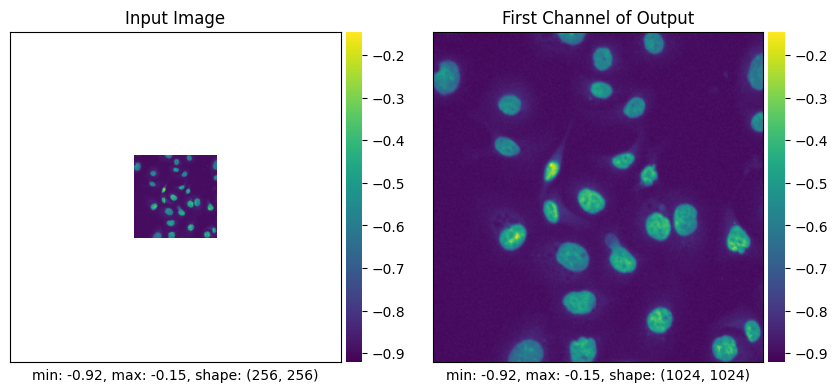

In [8]:
apply_and_show_random_image(up, dataset)

### Component 2: Downsampling

Between levels of the U-Net on the left side, there is a downsample step. Traditionally, this is done with a 2x2 max pooling operation. There are other ways to downsample, for example with average pooling, but we will stick with max pooling for this exercise.

In [9]:
sample_2d_input = torch.tensor(np.arange(25, dtype=np.float64).reshape((1, 1, 5, 5)))
sample_2d_input = torch.randint(0, 10, (1, 1, 6, 6))
sample_2d_input

tensor([[[[3, 2, 0, 3, 7, 9],
          [9, 2, 4, 0, 9, 1],
          [7, 6, 4, 6, 8, 8],
          [3, 2, 0, 8, 7, 0],
          [3, 5, 9, 1, 9, 9],
          [4, 1, 4, 3, 6, 3]]]])

<div class="alert alert-block alert-info">
    <h4>Task 2A: Try out max pooling</h4>
        <p>Using the docs for <a href=https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html>torch.nn.MaxPool2d</a>,
        try initializing the module and applying it to the sample input. Try varying the parameters to understand the effect of <code>kernel_size</code> and <code>stride</code>.
        </p>

In [10]:
# TASK 2A: Initialize max pooling and apply to sample input
# YOUR CODE HERE
down = torch.nn.MaxPool2d(kernel_size=(2,2), stride=1)
down(sample_2d_input)

tensor([[[[9, 4, 4, 9, 9],
          [9, 6, 6, 9, 9],
          [7, 6, 8, 8, 8],
          [5, 9, 9, 9, 9],
          [5, 9, 9, 9, 9]]]])

<div class="alert alert-block alert-info">
    <h4>Task 2B: Implement a Downsample Module</h4>
    <p>This is very similar to the built in MaxPool2d, but additionally has to check if the downsample factor matches in the input size. Note that we provide the forward function for you - in future Modules, you will implement the forward yourself.</p>
    <ol>
        <li>Declare the submodules you want to use (in this case, <code>torch.nn.MaxPool2d</code> with the correct arguments) in the <code>__init__</code> function. In our Downsample Module, we do not want to use padding and the stride should match the input kernel size.</li>
        <li>Write a function to check if the downsample factor is valid. If the downsample factor does not evenly divide the dimensions of the input to the layer, this function should return False.</li>
    </ol>
</div>

In [11]:
class Downsample(torch.nn.Module):
    def __init__(self, downsample_factor: int):
        """Initialize a MaxPool2d module with the input downsample fator"""

        super().__init__()

        self.downsample_factor = downsample_factor
        # TASK 2B1: Initialize the maxpool module
        self.down = torch.nn.MaxPool2d(kernel_size=(downsample_factor, downsample_factor))  # YOUR CODE HERE

    def check_valid(self, image_size: tuple[int, int]) -> bool:
        """Check if the downsample factor evenly divides each image dimension.
        Returns `True` for valid image sizes and `False` for invalid image sizes.
        Note: there are multiple ways to do this!
        """
        # TASK 2B2: Check that the image_size is valid to use with the downsample factor
        # YOUR CODE HERE
        if image_size[0] % self.downsample_factor == 0 and image_size[1] % self.downsample_factor == 0:
            return True
        else:
            return False

    def forward(self, x):
        if not self.check_valid(tuple(x.size()[-2:])):
            raise RuntimeError(
                "Can not downsample shape %s with factor %s"
                % (x.size(), self.downsample_factor)
            )

        return self.down(x)

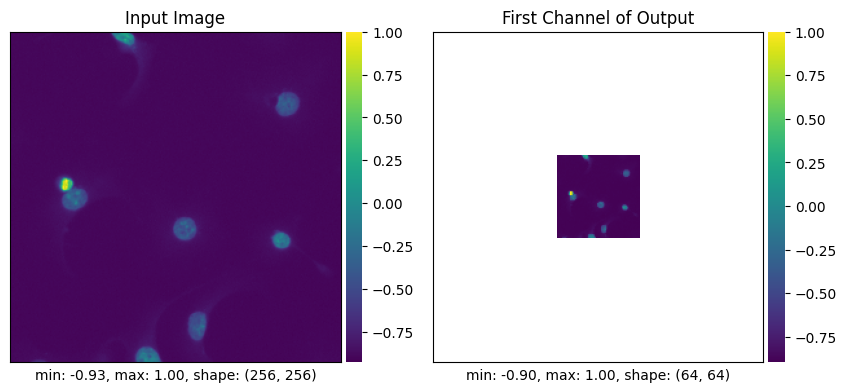

In [12]:
down = Downsample(4)
apply_and_show_random_image(down, dataset)

We wrote some rudimentary tests for each of the torch modules you are writing. If you get an error from your code or an AssertionError from the test, you should probably have another look ath your implementation.

In [13]:
unet_tests.TestDown(Downsample).run()

TESTS PASSED


### Component 3: Convolution Block

#### Convolution
A U-Net is a convolutional neural network, which means that the main type of operation is a convolution. Convolutions with defined kernels were covered briefly in the pre-course materials.

<img src="./static/2D_Convolution_Animation.gif" width="400" height="300">

Shown here is a 3x3 kernel being convolved with an input array to get an output array of the same size. For each pixel of the input, the value at that same pixel of the output is computed by multiplying the kernel element-wise with the surrounding 3x3 neighborhood around the input pixel, and then summing the result.

#### Padding

You will notice that at the edges of the input, this animation shows greyed out values that extend past the input. This is known as padding the input. This example uses "same" padding, which means the values at the edges are repeated. The other option we will use in this exercise is "valid" padding, which essentially means no padding. In the case of valid padding, the output will be smaller than the input, as values at the edges of the output will not be computed. "Same" padding can introduce edge artifacts, but "valid" padding reduces the output size at every convolution. Note that the amount of padding (for same) and the amount of size lost (for valid) depends on the size of the kernel - a 3x3 convolution would require padding of 1, a 5x5 convolution would require a padding of 2, and so on.

Additionally, there are different modes of padding that determine what strategy is used to make up the values for padding. In the animation above the mode is re-using values from the border. Even more commonly, the image is simply padded with zeros.

#### ReLU Activation
The Rectified Linear Unit (ReLU) is a common activation function, which takes the max of a value and 0, shown below. It introduces a non-linearity into the neural network - without a non-linear activation function, a neural network could not learn non-linear functions.

<img src="./static/ReLU.png" width="400" height="300">

<div class="alert alert-block alert-info">
    <h4>Task 3: Implement a ConvBlock module</h4>
    <p>The convolution block (ConvBlock) of a standard U-Net has two 3x3 convolutions, each of which is followed by a ReLU activation. Our implementation will handle other sizes of convolutions as well. The first convolution in the block will handle changing the input number of feature maps/channels into the output, and the second convolution will have the same number of feature maps in and out.</p>
    <ol>
        <li>Declare the submodules you want to use in the <code>__init__</code> function. Because you will always be calling four submodules in sequence (<a href=https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d>torch.nn.Conv2d</a>, <a href=https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU>torch.nn.ReLU</a>, Conv2d, ReLU), you can use <a href=https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html>torch.nn.Sequential</a> to hold the convolutions and ReLUs.</li>
        <li>Call the modules in the forward function. If you used <code>torch.nn.Sequential</code> in step 1, you only need to call the Sequential module, but if not, you can call the Conv2d and ReLU Modules explicitly.</li>
    </ol>
</div>

If you get stuck, refer back to the <a href=https://pytorch.org/docs/stable/notes/modules.html>Module</a> documentation for hints and examples of how to define a PyTorch Module.

In [14]:
class ConvBlock(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        padding: str = "same",
    ):
        """A convolution block for a U-Net. Contains two convolutions, each followed by a ReLU.

        Args:
            in_channels (int): The number of input channels for this conv block. Depends on
                the layer and side of the U-Net and the hyperparameters.
            out_channels (int): The number of output channels for this conv block. Depends on
                the layer and side of the U-Net and the hyperparameters.
            kernel_size (int): The size of the kernel. A kernel size of N signifies an
                NxN square kernel.
            padding (str): The type of convolution padding to use. Either "same" or "valid".
                Defaults to "same".
        """
        super().__init__()

        if kernel_size % 2 == 0:
            msg = "Only allowing odd kernel sizes."
            raise ValueError(msg)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding

        # TASK 3.1: Initialize your modules and define layers.
        # YOUR CODE HERE
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
            torch.nn.ReLU()
        )

        for _name, layer in self.named_modules():
            if isinstance(layer, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(layer.weight, nonlinearity="relu")

    def forward(self, x):
        # TASK 3.2: Apply the modules you defined to the input x
        return self.layers(x)  # YOUR CODE HERE

#### Test and Visualize Output of ConvBlock
Try rerunning the visualization a few times. What do you observe? Can you explain it?

In [15]:
unet_tests.TestConvBlock(ConvBlock).run()

TESTS PASSED


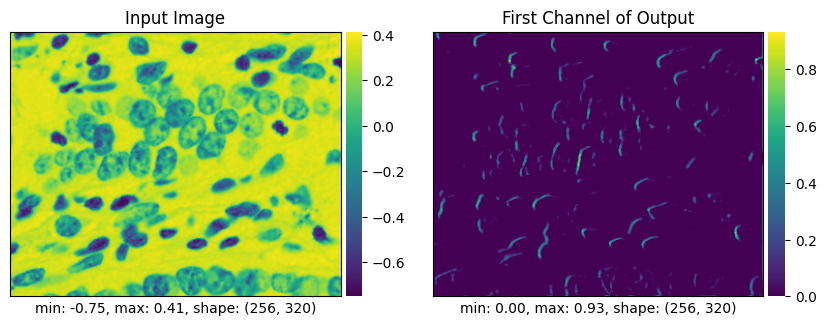

In [16]:
torch.manual_seed(26)
conv = ConvBlock(1, 2, 5, "same")
apply_and_show_random_image(conv, dataset)

<div class="alert alert-warning">

<h4>Question: Padding</h4>
As you saw, the convolution modules in pytorch allow you to directly use the keywords <code>"valid"</code> or <code>"same"</code> for your padding mode. How would you go about calculating the amount of padding you need based on the kernel size?

If you'd like, you can test your assumption by editing the `ConvBlock` to pass your own calculated value to the `padding` keyword in the conv module and rerun the test
</div>

### Component 4: Skip Connections and Concatenation

The skip connections between the left and right side of the U-Net are central to successfully obtaining high-resolution output. At each layer, the output of the left conv block is concatenated to the output of the upsample block on the right side from the last layer below. Since upsampling, especially with the "nearest" algorithm, does not actually add high resolution information, the concatenation of the left side conv block output is crucial to generate high resolution segmentations.

If the convolutions in the U-Net are valid, the right side will be smaller than the left side, so the left side output must be cropped before concatenation. We provide a helper function to do this cropping.

<div class="alert alert-block alert-info">
    <h4>Task 4: Implement a CropAndConcat module</h4>
    <p>Below, you must implement the <code>forward</code> method, including the cropping (using the provided helper function <code>center_crop</code>) and the concatenation (using <a href=https://pytorch.org/docs/stable/generated/torch.cat.html#torch.cat>torch.cat</a>).
</p>
Hint: Use the <code>dim</code> keyword argument of <a href=https://pytorch.org/docs/stable/generated/torch.cat.html#torch.cat>torch.cat</a> to choose along which axis to concatenate the tensors.
</p>
Hint: The tensors have the layout (batch, channel, x, y)
</div>

In [17]:
def center_crop(x, target_spatial_shape):
    """Center-crop x to match spatial dimensions given by target_spatial_shape."""

    x_target_size = x.size()[:2] + torch.Size(target_spatial_shape)

    offset = tuple((a - b) // 2 for a, b in zip(x.size(), x_target_size))

    slices = tuple(slice(o, o + s) for o, s in zip(offset, x_target_size))

    return x[slices]


class CropAndConcat(torch.nn.Module):
    def forward(self, encoder_output, upsample_output):
        upsample_spatial_shape = upsample_output.size()[2:]
        # TASK 4: Implement the forward function
        cropped = center_crop(encoder_output, upsample_spatial_shape)
        return torch.cat([cropped, upsample_output], dim=1)

In [18]:
unet_tests.TestCropAndConcat(CropAndConcat).run()

TESTS PASSED


### Component 5: Output Block

The final block we need to write for our U-Net is the output convolution block. The exact format of output you want depends on your task, so our U-Net must be flexible enough to handle different numbers of out channels and different final activation functions.

<div class="alert alert-block alert-info">
    <h4>Task 5: Implement an OutputConv Module</h4>
    <ol>
        <li>Define the convolution module in the <code>__init__</code> function. You can use a convolution with kernel size 1 to get the appropriate number of output channels. The activation submodule is provided for you.</li>
        <li>Call the final convolution and activation modules in the <code>forward</code> function</li>
    </ol>
</div>

In [19]:
class OutputConv(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        activation: torch.nn.Module | None = None,
    ):
        """
        A module that uses a convolution with kernel size 1 to get the appropriate
        number of output channels, and then optionally applies a final activation.

        Args:
            in_channels (int): The number of feature maps that will be input to the
                OutputConv block.
            out_channels (int): The number of channels that you want in the output
            activation (str | None, optional): Accepts the name of any torch activation
                function  (e.g., ``ReLU`` for ``torch.nn.ReLU``) or None for no final
                activation. Defaults to None.
        """
        super().__init__()

        # TASK 5.1: Define the convolution submodule
        # YOUR CODE HERE
        self.out_conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1))

        self.activation = activation

    def forward(self, x):
        # TASK 5.2: Implement the forward function
        # YOUR CODE HERE
        x = self.out_conv(x)
        if self.activation is not None:
            return self.activation(x)
        else:
            return x

In [20]:
unet_tests.TestOutputConv(OutputConv).run()

TESTS PASSED


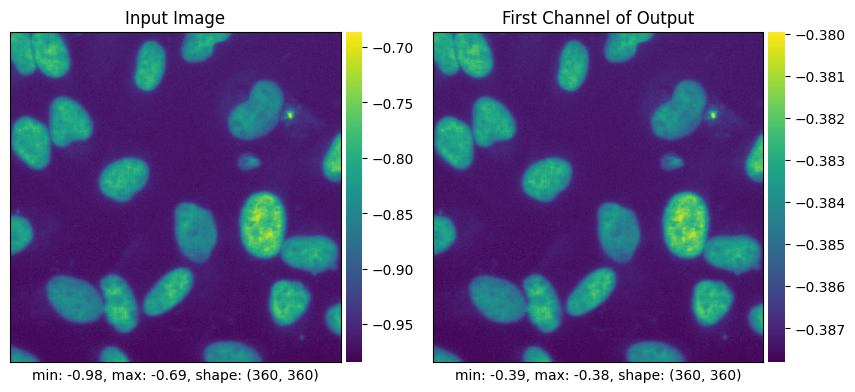

In [21]:
out_conv = OutputConv(in_channels=1, out_channels=1, activation=None)
apply_and_show_random_image(out_conv, dataset)

<div class="alert alert-block alert-success">
    <h2>Checkpoint 1</h2>

Congratulations! You have implemented most of a U-Net!
We will go over this portion together and answer any questions soon, but feel free to start on the next section where we put it all together.

</div>

<hr style="height:2px;">

## Putting the U-Net together

Now we will make a U-Net class that combines all of these components as shown in the image. This image shows a U-Net of depth 4 with specific input channels, feature maps, upsampling, and final activation. Ours will be configurable with regards to depth and other features.

<img src="static/unet.png" alt="UNet" style="width: 1500px;"/>

<div class="alert alert-block alert-info">
    <h4>Task 6: U-Net Implementation</h4>
    <p>Now we will implement our U-Net! We have written some of it for you - follow the steps below to fill in the missing parts.</p>
    <ol>
        <li>Declare a list of encoder (left) and decoder (right) ConvPasses. Carefully consider the input and output feature maps for each ConvPass!</li>
        <li>Declare an Upsample, Downsample, CropAndConcat, and OutputConv block.</li>
        <li>Implement the <code>forward</code> function, applying the modules you declared above in the proper order.</li>
        </ol>
</div>

In [ ]:
class UNet(torch.nn.Module):
    def __init__(
        self,
        depth: int,
        in_channels: int,
        out_channels: int = 1,
        final_activation: torch.nn.Module | None = None,
        num_fmaps: int = 64,
        fmap_inc_factor: int = 2,
        downsample_factor: int = 2,
        kernel_size: int = 3,
        padding: str = "same",
        upsample_mode: str = "nearest",
    ):
        """A U-Net for 2D input that expects tensors shaped like::
            ``(batch, channels, height, width)``.
        Args:
            depth:
                The number of levels in the U-Net. 2 is the smallest that really
                makes sense for the U-Net architecture, as a one layer U-Net is
                basically just 2 conv blocks.
            in_channels:
                The number of input channels in your dataset.
            out_channels (optional):
                How many output channels you want. Depends on your task. Defaults to 1.
            final_activation (optional):
                What activation to use in your final output block. Depends on your task.
                Defaults to None.
            num_fmaps (optional):
                The number of feature maps in the first layer. Defaults to 64.
            fmap_inc_factor (optional):
                By how much to multiply the number of feature maps between
                layers. Encoder layer ``l`` will have ``num_fmaps*fmap_inc_factor**l``
                output feature maps. Defaults to 2.
            downsample_factor (optional):
                Factor to use for down- and up-sampling the feature maps between layers.
                Defaults to 2.
            kernel_size (optional):
                Kernel size to use in convolutions on both sides of the UNet.
                Defaults to 3.
            padding (optional):
                How to pad convolutions. Either 'same' or 'valid'. Defaults to "same."
            upsample_mode (optional):
                The upsampling mode to pass to torch.nn.Upsample. Usually "nearest"
                or "bilinear." Defaults to "nearest."
        """

        super().__init__()

        self.depth = depth
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.final_activation = final_activation
        self.num_fmaps = num_fmaps
        self.fmap_inc_factor = fmap_inc_factor
        self.downsample_factor = downsample_factor
        self.kernel_size = kernel_size
        self.padding = padding
        self.upsample_mode = upsample_mode

        # left convolutional passes
        self.left_convs = torch.nn.ModuleList()
        # TASK 6.1A: Initialize list here
        # Loop through each level of the encoder from top (level=0) to bottom (level=self.depth - 1)
        in_fmap = self.in_channels
        for level in range(self.depth): 
            out_fmap = num_fmaps*fmap_inc_factor**level
            conv = ConvBlock(in_channels=in_fmap, out_channels=out_fmap, kernel_size=self.kernel_size, padding=padding)
            # Adding conv module to the list
            self.left_convs.append(conv)
            in_fmap = out_fmap

        # right convolutional passes
        self.right_convs = torch.nn.ModuleList()
        # TASK 6.1B: Initialize list here
        # Loop through each level of the decoder from top (level=0) to one above bottom (level=self.depth - 2)
        for level in range(self.depth - 1):
            # Initialize conv module
            out_fmap = num_fmaps*fmap_inc_factor**level
            conv = ConvBlock(in_channels=int(out_fmap * 1.5), out_channels=out_fmap, kernel_size=kernel_size, padding=padding)
            # Adding conv module to the list
            self.right_convs.append(conv)
        
        # TASK 6.2: Initialize other modules here
        self.upsample = torch.nn.Upsample(scale_factor=downsample_factor, mode=upsample_mode)
        self.downsample = Downsample(downsample_factor=downsample_factor)
        self.cropncat = CropAndConcat()
        self.outconv = OutputConv(in_channels=num_fmaps, out_channels=out_channels, activation=final_activation)
        self.bottom_conv = ConvBlock(in_channels=num_fmaps*fmap_inc_factor**(depth - 1), out_channels=num_fmaps*fmap_inc_factor**depth, kernel_size=(3,3), padding=padding)

    def forward(self, x):
        # left side
        # Hint - you will need the outputs of each convolutional block in the encoder for the skip connection, so you need to hold on to those output tensors
        left_outputs = []
        for i in range(self.depth - 1):
            # TASK 6.3A: Implement encoder here
            x = self.left_convs[i](x)
            left_outputs.append(x)
            x = self.downsample(x)

        # bottom
        # TASK 6.3B: Implement bottom of U-Net here
        x = self.bottom_conv(x)
        x = self.upsample(x)

        # right
        for i in range(0, self.depth - 1)[::-1]:
            # TASK 6.3C: Implement decoder here
            x = self.cropncat(self.left_convs[i], x)
            x = self.right_convs[i](x)
            if i != 0:
                x = self.upsample(x)
        # TASK 6.3D: Apply the final convolution and return the output
        return self.outconv(x)

Below we declare a very simple U-Net and then apply it to a random image. Because we have not trained the U-Net the output should look similar to the output of random convolutions. If you get errors here, go back and fix your U-Net implementation!

In [23]:
unet_tests.TestUNet(UNet).run()

AssertionError: The number of feature maps in the decoder is incorrect

In [24]:
simple_net = UNet(depth=2, in_channels=1)

In [30]:
simple_net.right_convs[0].in_channels

96

In [ ]:
apply_and_show_random_image(simple_net, dataset)

<div class="alert alert-block alert-success">
    <h2>Checkpoint 2</h2>

Congratulations! You have implemented a UNet architecture.

Next we'll learn about receptive fields which should demistify how to choose the UNet hyperparameters a little bit.


<hr style="height:2px;">

## Receptive Field

The receptive field of an output value is the set of input values that can change the output value. The size of the receptive field is an important property of network architectures for image processing. Let's consider the receptive field size of the U-Net building blocks.

<div class="alert alert-warning">

<h4>Question: Receptive Field Size</h4>
What are the receptive field sizes of the following operations?

1. <code>torch.nn.Conv2d(1, 5, 3)</code>
2. <code>torch.nn.Sequential(torch.nn.Conv2d(1, 5, 3), torch.nn.Conv2d(5,5,3))</code>
3. <code>torch.nn.Sequential(torch.nn.Conv2d(1, 5, 3), torch.nn.Conv2d(5,5,5))</code>
4. <code>Downsample(3)</code>
5. <code>torch.nn.Sequential(ConvBlock(1, 5, 3), Downsample(2), ConvBlock(5,5,3)</code>
6. <code>torch.nn.Upsample(2)</code>
7. <code>torch.nn.Sequential(ConvBlock(1,5,3), Upsample(2), ConvBlock(5,5,3))</code>
8. <code>torch.nn.Sequential(ConvBlock(1,5,3), Downsample(3), ConvBlock(5,5,3), Upsample(3), ConvBlock(5,5,3))</code>
9. <code>UNet(depth=2, in_channels=1, downsample_factor=3, kernel_size=3)</code>


</div>

<div class="alert alert-block alert-info">
    <h4>Task 7: Receptive Field</h4>
    <p>The <code>plot_receptive_field</code> function visualizes the receptive field of a given U-Net - the square shows how many input pixels contribute to the output at the center pixel. Try it out with different U-Nets to get a sense of how varying the depth, kernel size, and downsample factor affect the receptive field of a U-Net.</p>
</div>

In [ ]:
new_net = ...  # TASK 7: declare your U-Net here
if isinstance(new_net, UNet):
    plot_receptive_field(new_net)

<div class="alert alert-block alert-success">
    <h2>Checkpoint 3</h2>

Looking at the receptive field of your network is one of the most important aspects to consider when you choose the hyperparameters for your network.

Questions to consider:
<ol>
    <li>Which hyperparameter of the U-Net has most effect on the receptive field?</li>
    <li>If two sets of hyperparameters result in the same receptive field size are those networks equally good choices?</li>
    <li>What's the relation between the receptive field size and the size of images you feed to your UNet?</li>
    <li>Do you see a connection between padding and receptive field size?</li>
    <li>For each hyperparameter: Can you think of scenarios in which you would consider changing this parameter? Why? </li>
</ol>

</div>

<hr style="height:2px;">

## Translational equivariance

Depending on the task you're trying to solve you may care about translational (shift) invariance or equivariance.

Let's first define what these invariance and equivariance mean in mathematical notation.

Let $T$ be a transformation and $F$ the function whose properties we're considering.

$F$ is invariant under transformation $T$ if: $F(T(x)) = F(x)$. The output of the function remains the same whether the input was transformed or not.

$F$ is equivariant under transformation $T$ if: $F(T(x)) = T(F(x))$. Applying the function on the transformed input is the same as applying the transformation on the output of the original input.

If math isn't your thing hopefully this picture helps to convey the concept, now specifically for translations.

<img src="static/equivariance.png" alt="Invariance and Equivariance" style="width: 1500px;"/>

<div class="alert alert-warning">

<h4>Question: Translational invariance and equivariance</h4>
For what types of deep learning tasks would you want your network to be translationally invariant and equivariant, respectively? Where does the U-Net fit in?
</div>

<div class="alert alert-warning">

<h4>Question: Translational properties of U-Net building blocks</h4>
For each of these building blocks of the U-Net: Is it translationally equivariant or invariant?
<ol>
    <li>ConvBlock</li>
    <li>Downsample</li>
    <li>Upsample</li>
</ol>
</div>

<div class="alert alert-block alert-success">
    <h2>Checkpoint 4</h2>


Questions and points to consider:
<ol>
    <li>How the output of your network behaves under translations becomes particularly important when your images are too large to be fed into your network as a whole. To solve this the input image is split into tiles and ideally their output should fit together seamlessly. Do you see how seamless stitching is equivalent to translational equivariance under shifts under your tile size and multiples thereof?</li>
    <li>How does padding affect the translational equivariance of your network?</li>
    <li>Can you think of ways to design an architecture to achieve translation invariance?</li>
</ol>

</div>

<hr style="height:2px;">

## Train a U-Net!
We will get more into the details of evaluating semantic segmentation models in the next exercise. For now, we will provide an example pipeline that will train a U-Net to classify each pixel in an image of cells as foreground or background. You should have seen training loops like this in the pre-course exercises, so there is no implementation task here.

We will use Tensorboard to log our training runs, so there is code in the train loop to log aspects of the training to Tensorboard.

In [ ]:
train_dataset = NucleiDataset("nuclei_train_data", transforms.RandomCrop(256))
train_loader = DataLoader(train_dataset)

In [ ]:
loss_function: torch.nn.Module = torch.nn.MSELoss()

In [ ]:
# apply training for one epoch
def train(
    model,
    loader,
    optimizer,
    loss_function,
    epoch,
    log_interval=100,
    log_image_interval=20,
    tb_logger=None,
    device=None,
    early_stop=False,
):
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")

    # set the model to train mode
    model.train()

    # move model to device
    model = model.to(device)

    # iterate over the batches of this epoch
    for batch_id, (x, y) in enumerate(loader):
        # move input and target to the active device (either cpu or gpu)
        x, y = x.to(device), y.to(device)

        # zero the gradients for this iteration
        optimizer.zero_grad()

        # apply model and calculate loss
        prediction = model(x)
        # if necessary, crop the masks to match the model output shape
        if prediction.shape != y.shape:
            y = center_crop(y, prediction.size()[2:])
        if y.dtype != prediction.dtype:
            y = y.type(prediction.dtype)
        loss = loss_function(prediction, y)

        # backpropagate the loss and adjust the parameters
        loss.backward()
        optimizer.step()

        # log to console
        if batch_id % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_id * len(x),
                    len(loader.dataset),
                    100.0 * batch_id / len(loader),
                    loss.item(),
                )
            )

        # log to tensorboard
        if tb_logger is not None:
            step = epoch * len(loader) + batch_id
            tb_logger.add_scalar(
                tag="train_loss", scalar_value=loss.item(), global_step=step
            )
            # check if we log images in this iteration
            if step % log_image_interval == 0:
                x = unnormalize(x)
                tb_logger.add_images(
                    tag="input", img_tensor=x.to("cpu"), global_step=step
                )
                tb_logger.add_images(
                    tag="target", img_tensor=y.to("cpu"), global_step=step
                )
                tb_logger.add_images(
                    tag="prediction",
                    img_tensor=prediction.to("cpu").detach(),
                    global_step=step,
                )
                combined_image = torch.cat(
                    [x, pad_to_size(y, x.size()), pad_to_size(prediction, x.size())],
                    dim=3,
                )

                tb_logger.add_images(
                    tag="input_target_prediction",
                    img_tensor=combined_image,
                    global_step=step,
                )

        if early_stop and batch_id > 5:
            print("Stopping test early!")
            break

The next two cells start tensorboard.
<div class="alert alert-warning">
If you are using VSCode and a remote server, you will need to forward the port to view the tensorboard. <br>
Take note of the port number was assigned in the previous cell.(i.e <code> http://localhost:{port_number_assigned}</code>) <br>

Locate the your VSCode terminal and select the <code>Ports</code> tab <br>
<ul>
<li>Add a new port with the <code>port_number_assigned</code>
</ul>
Click on the link to view the tensorboard and it should open in your browser.
</div>
<div class="alert alert-warning">
If you launched jupyter lab from ssh terminal, add <code>--host &lt;your-server-name&gt;</code> to the tensorboard command below. <code>&lt;your-server-name&gt;</code> is the address of your compute node that ends in amazonaws.com.

</div>

In [ ]:
# Function to find an available port
def find_free_port():
    import socket

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(("", 0))
        return s.getsockname()[1]


# Launch TensorBoard on the browser
def launch_tensorboard(log_dir):
    port = find_free_port()
    tensorboard_cmd = f"tensorboard --logdir={log_dir} --port={port}"
    process = subprocess.Popen(tensorboard_cmd, shell=True)
    print(
        f"TensorBoard started at http://localhost:{port}. \n"
        "If you are using VSCode remote session, forward the port using the PORTS tab next to TERMINAL."
    )
    return process

In [ ]:
# Launch tensorboard and click on the link to view the logs.
tensorboard_process = launch_tensorboard("unet_runs")

<div class="alert alert-block alert-info">
    <h3>Task 8: Declare and train a U-Net</h3>
    <ol>
        <li>Declare a U-Net with your favorite parameters!</li>
        <li>Train the U-Net for 5 epochs, and inspect the training loss and the output predictions in Tensorboard.</li>
        </ol>
</div>

In [ ]:
model = ...  # TASK 8.1: Declare your U-Net here and name it below
model_name = "my_fav_unet"  # This name will be used in the tensorboard logs
logger = SummaryWriter(f"unet_runs/{model_name}")

In [ ]:
# use adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train for $5$ epochs
# TASK 8.2: Run this cell and examine outputs in Tensorboard above!
n_epochs = 5
for epoch in range(n_epochs):
    # train
    train(
        model,
        train_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        epoch=epoch,
        tb_logger=logger,
    )

<div class="alert alert-block alert-info">
    <h3>Task 9: Train more U-Nets! </h3>
    <ol>
        <li>Declare a new U-Net with different parameters. If you use a different name in the Tensorboard logger, you will be able to know which logs are from which run.</li>
        <li>Train your new U-Net - does it perform better or worse? How can you tell?</li>
        <li>Keep tinkering with different architectures until the end of the exercise!</li>
        </ol>
</div>

<div class="alert alert-block alert-success">
    <h2>Checkpoint 5</h2>

Congratulations! You trained your first UNet that you implemented all by yourself!

We will keep using this U-Net throughout the rest of the exercises. Whenever you see an import like `import dlmbl-unet` or
`from dlmbl-unet import UNet` it will be importing from [this repository](https://github.com/dlmbl/dlmbl-unet) which contains the solution to this notebook as a package (including the bonus exercises so don't peek just yet if you wanna solve the bonus too).
</div>

## Bonus 1: 3D UNet
The UNet you implemented so far only works for 2D images, but in microscopy we often have 3D data that also needs to be processed as such, i.e. for some tasks it is important that the network's receptive field is 3D. So in this bonus exercise we will change our implementation to make the number of dimensions configurable.


<div class="alert alert-block alert-info">
    <h3>Task 10: Make U-Net building blocks configurable for 2D and 3D data! </h3>
    To make the same class usable for 2D and 3D data we will add an argument `ndim` to each building block.
</div>

In [ ]:
class Downsample(torch.nn.Module):
    def __init__(self, downsample_factor: int, ndim: int = 2):
        """Initialize a MaxPool2d module with the input downsample fator"""

        super().__init__()
        if ndim not in (2, 3):
            msg = f"Invalid number of dimensions: {ndim=}. Options are 2 or 3."
            raise ValueError(msg)
        self.ndim = ndim
        self.downsample_factor = downsample_factor
        # TASK 10A: Initialize the maxpool module
        # Define what the downop should be based on `ndim`.
        self.down = ...  # YOUR CODE HERE

    def check_valid(self, image_size: tuple[int, ...]) -> bool:
        """Check if the downsample factor evenly divides each image dimension.
        Returns `True` for valid image sizes and `False` for invalid image sizes.
        Note: there are multiple ways to do this!
        """
        # TASK 10B: Check that the image_size is valid to use with the downsample factor
        # YOUR CODE HERE
        # You can likely copy this from Task 2B2

    def forward(self, x):
        if not self.check_valid(tuple(x.size()[-self.ndim:])):
            raise RuntimeError(
                "Can not downsample shape %s with factor %s"
                % (x.size(), self.downsample_factor)
            )

        return self.down(x)

In [ ]:
class ConvBlock(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        padding: str = "same",
        ndim: int = 2,
    ):
        """A convolution block for a U-Net. Contains two convolutions, each followed by a ReLU.

        Args:
            in_channels (int): The number of input channels for this conv block. Depends on
                the layer and side of the U-Net and the hyperparameters.
            out_channels (int): The number of output channels for this conv block. Depends on
                the layer and side of the U-Net and the hyperparameters.
            kernel_size (int): The size of the kernel. A kernel size of N signifies an
                NxN square kernel.
            padding (str): The type of convolution padding to use. Either "same" or "valid".
                Defaults to "same".
            ndim (int): Number of dimensions for the convolution operation. Use 2 for 2D
                convolutions and 3 for 3D convolutions. Defaults to 2.
        """
        super().__init__()
        if ndim not in (2, 3):
            msg = f"Invalid number of dimensions: {ndim=}. Options are 2 or 3."
            raise ValueError(msg)
        if kernel_size % 2 == 0:
            msg = "Only allowing odd kernel sizes."
            raise ValueError(msg)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding

        # TASK 10C: Initialize your modules and define layers.
        # Use the convolution module matching `ndim`.
        # YOUR CODE HERE

        for _name, layer in self.named_modules():
            if isinstance(layer, (torch.nn.Conv2d, torch.nn.Conv3d)):
                torch.nn.init.kaiming_normal_(layer.weight, nonlinearity="relu")

    def forward(self, x):
        # TASK 10D: Apply the modules you defined to the input x
        ...  # YOUR CODE HERE

In [ ]:
class OutputConv(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        activation: torch.nn.Module | None = None,
        ndim: int = 2,
    ):
        """
        A module that uses a convolution with kernel size 1 to get the appropriate
        number of output channels, and then optionally applies a final activation.

        Args:
            in_channels (int): The number of feature maps that will be input to the
                OutputConv block.
            out_channels (int): The number of channels that you want in the output
            activation (str | None, optional): Accepts the name of any torch activation
                function  (e.g., ``ReLU`` for ``torch.nn.ReLU``) or None for no final
                activation. Defaults to None.
            ndim (int): Number of dimensions for convolution operation. Use 2 for 2D
                convolutions and 3 for 3D convolutions. Defaults to 2.
        """
        super().__init__()
        if ndim not in (2, 3):
            msg = f"Invalid number of dimensions: {ndim=}. Options are 2 or 3."
            raise ValueError(msg)

        # TASK 10E: Define the convolution submodule.
        # Use the convolution module matching `ndim`.
        # YOUR CODE HERE

        self.activation = activation

    def forward(self, x):
        # TASK 10F: Implement the forward function
        # YOUR CODE HERE
        ...

In [ ]:
class UNet(torch.nn.Module):
    def __init__(
        self,
        depth: int,
        in_channels: int,
        out_channels: int = 1,
        final_activation: torch.nn.Module | None = None,
        num_fmaps: int = 64,
        fmap_inc_factor: int = 2,
        downsample_factor: int = 2,
        kernel_size: int = 3,
        padding: str = "same",
        upsample_mode: str = "nearest",
        ndim: int = 2,
    ):
        """A U-Net for 2D or 3D input that expects tensors shaped like:
            ``(batch, channels, height, width)`` or ``(batch, channels, depth, height, width)``,
            respectively.

        Args:
            depth:
                The number of levels in the U-Net. 2 is the smallest that really
                makes sense for the U-Net architecture, as a one layer U-Net is
                basically just 2 conv blocks.
            in_channels:
                The number of input channels in your dataset.
            out_channels (optional):
                How many output channels you want. Depends on your task. Defaults to 1.
            final_activation (optional):
                What activation to use in your final output block. Depends on your task.
                Defaults to None.
            num_fmaps (optional):
                The number of feature maps in the first layer. Defaults to 64.
            fmap_inc_factor (optional):
                By how much to multiply the number of feature maps between
                layers. Encoder layer ``l`` will have ``num_fmaps*fmap_inc_factor**l``
                output feature maps. Defaults to 2.
            downsample_factor (optional):
                Factor to use for down- and up-sampling the feature maps between layers.
                Defaults to 2.
            kernel_size (int, optional):
                Kernel size to use in convolutions on both sides of the UNet.
                Defaults to 3.
            padding (str, optional):
                How to pad convolutions. Either 'same' or 'valid'. Defaults to "same."
            upsample_mode (str, optional):
                The upsampling mode to pass to torch.nn.Upsample. Usually "nearest"
                or "bilinear." Defaults to "nearest."
            ndim (int, optional): Number of dimensions for the U-Net. Use 2 for 2D U-Net and
                3 for 3D U-Net. Defaults to 2.
        """

        super().__init__()
        if ndim not in (2, 3):
            msg = f"Invalid number of dimensions: {ndim=}. Options are 2 or 3."
            raise ValueError(msg)
        self.depth = depth
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.final_activation = final_activation
        self.num_fmaps = num_fmaps
        self.fmap_inc_factor = fmap_inc_factor
        self.downsample_factor = downsample_factor
        self.kernel_size = kernel_size
        self.padding = padding
        self.upsample_mode = upsample_mode

        # left convolutional passes
        self.left_convs = torch.nn.ModuleList()
        # TASK 10G: Initialize list here
        # Loop through each level of the encoder from top (level=0) to bottom (level=self.depth - 1)
        for level in range(self.depth): 
            # conv = 
            # Adding conv module to the list
            self.left_convs.append(conv)

        # right convolutional passes
        self.right_convs = torch.nn.ModuleList()
        # TASK 10H: Initialize list here
        # Loop through each level of the decoder from top (level=0) to one above bottom (level=self.depth - 2)
        for level in range(self.depth - 1):
            # Initialize conv module
            # conv = 
            # Adding conv module to the list
            self.right_convs.append(conv)

        # TASK 10I: Initialize other modules here
        # Same here, copy over from TASK 6.2, but make sure to add the ndim argument
        # as needed.

    def forward(self, x):
        # left side
        # Hint - you will need the outputs of each convolutional block in the encoder for the skip connection, so you need to hold on to those output tensors
        for i in range(self.depth - 1):
            # TASK 10L: Implement encoder here
            # Copy from TASK 6.3A
            ...

        # bottom
        # TASK 10M: Implement bottom of U-Net here
        # Copy from TASK 6.3B

        # right
        for i in range(0, self.depth - 1)[::-1]:
            # TASK 10N: Implement decoder here
            # Copy from TASK 6.3C
            ...
        # TASK 10O: Apply the final convolution and return the output
        # Copy from TASK 6.3D
        return

Run the 3d test for your implementation of the UNet.

In [ ]:
unet_tests.TestUNet(UNet).run3d()

## Bonus 2: Tilable UNet
In order to process arbitrarily large images, we can divide the image into smaller tiles and process each tile separately. To avoid artifacts at tile boundaries, the U-Net needs to be equivariant w.r.t. translations by the tile size. Add a cropping layer at the end of the U-Net that crops the output to a size for which the U-Net is equivariant. Can tranlsational equivariance be achieved for any parameter setting?

<div class="alert alert-block alert-info">
    <h3>Task 11: Implement a Tilable U-Net</h3>
    <p>Modify the U-Net to make it suitable for processing large images by tiling. You'll need to add a cropping
         mechanism to ensure translational equivariance.</p>
    <ol>
        <li>Copy over your UNet implemntation from Task 10.</li>
        <li>Crop the output of the U-Net to an appropriate tile size</li>
        <li>Add a conditional to only crop the outputs for U-Nets that can be translation equivariant.</li>
    </ol>
</div>

In [ ]:
class UNet(torch.nn.Module):
    def __init__(
        self,
        depth: int,
        in_channels: int,
        out_channels: int = 1,
        final_activation: torch.nn.Module | None = None,
        num_fmaps: int = 64,
        fmap_inc_factor: int = 2,
        downsample_factor: int = 2,
        kernel_size: int = 3,
        padding: str = "same",
        upsample_mode: str = "nearest",
        ndim: int = 2,
    ):
        """A U-Net for 2D or 3D input that expects tensors shaped like:
          ``(batch, channels, height, width)`` or ``(batch, channels, depth, height, width)``,
          respectively.
      Args:
          depth:
              The number of levels in the U-Net. 2 is the smallest that really
              makes sense for the U-Net architecture, as a one layer U-Net is
              basically just 2 conv blocks.
          in_channels:
              The number of input channels in your dataset.
          out_channels (optional):
              How many output channels you want. Depends on your task. Defaults to 1.
          final_activation (optional):
              What activation to use in your final output block. Depends on your task.
              Defaults to None.
          num_fmaps (optional):
              The number of feature maps in the first layer. Defaults to 64.
          fmap_inc_factor (optional):
              By how much to multiply the number of feature maps between
              layers. Encoder layer ``l`` will have ``num_fmaps*fmap_inc_factor**l``
              output feature maps. Defaults to 2.
          downsample_factor (optional):
              Factor to use for down- and up-sampling the feature maps between layers.
              Defaults to 2.
          kernel_size (int, optional):
              Kernel size to use in convolutions on both sides of the UNet.
              Defaults to 3.
          padding (str, optional):
              How to pad convolutions. Either 'same' or 'valid'. Defaults to "same."
          upsample_mode (str, optional):
              The upsampling mode to pass to torch.nn.Upsample. Usually "nearest"
              or "bilinear." Defaults to "nearest."
          ndim (int, optional): Number of dimensions for the U-Net. Use 2 for 2D U-Net and
              3 for 3D U-Net. Defaults to 2.
      """
        super().__init__()
        # TASK 11.1: Initialize the modules of the U-Net
        # Copy from TASK 10
        
    def forward(self, x):
        # TASK 11.1: Apply the modules of the U-Net
        # Copy from TASK 10
        
        # TASK 11.3: Add conditional 
        
        # TASK 11.2: Crop the output of the U-Net to an appropriate tile size
        
        return

In [ ]:
unet_tests.TestUNet(UNet).run3d_tiled()